# Forward prediction of Hindi hate speech content in `CrowdTangle` dataset

## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 14.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.9/441.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 13.6 MB/s eta 0:00:00
  Attempting unins

In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

## Load the `CrowdTangle` dataset
> This is the dataset over which sentiment analysis has already been performed

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv ('/content/drive/My Drive/CrowdTangle-NLP/CT_sentiment.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.shape

(604703, 41)

In [6]:
df.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

## Data preprocessing

Replace NaN values in particular columns with empty string

In [7]:
df.message = df.message.fillna('')

Extract particular columns and convert into lists

In [8]:
message_list = df ['message'].tolist()

print ("Total number of entries in the dataset:", len(message_list))

Total number of entries in the dataset: 604703


## Load the hate speech analysis model and the tokenizer


Define parameters

In [9]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 16

labels_ids = {'non-hate': 0, 'hate': 1}

n_labels = len(labels_ids)

max_length = 312

MODEL = "Rewire/XTC"

Load the model and the tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

config = AutoConfig.from_pretrained(MODEL) # used for id to label name (optional)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

Downloading:   0%|          | 0.00/358 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/741 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Define the forward prediction functions

In [11]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [13]:
def hatespeech_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  hate_pred = []

  for idx, batch in enumerate(dl):
    if idx % 100 == 0:
      print('Batch ',idx+1,' of ', len(dl))

    if (batch != ''):
      scores = forward(batch, cuda=CUDA)
      preds = np.argmax(scores, axis=-1)
    else:
      preds = 1
    hate_pred.extend(preds)
  
  return hate_pred

## Run hate speech prediction task on the dataset and save the results

In [14]:
message_hatespeech_score = hatespeech_pred_score (message_list)

Batch  1  of  37794
Batch  101  of  37794
Batch  201  of  37794
Batch  301  of  37794
Batch  401  of  37794
Batch  501  of  37794
Batch  601  of  37794
Batch  701  of  37794
Batch  801  of  37794
Batch  901  of  37794
Batch  1001  of  37794
Batch  1101  of  37794
Batch  1201  of  37794
Batch  1301  of  37794
Batch  1401  of  37794
Batch  1501  of  37794
Batch  1601  of  37794
Batch  1701  of  37794
Batch  1801  of  37794
Batch  1901  of  37794
Batch  2001  of  37794
Batch  2101  of  37794
Batch  2201  of  37794
Batch  2301  of  37794
Batch  2401  of  37794
Batch  2501  of  37794
Batch  2601  of  37794
Batch  2701  of  37794
Batch  2801  of  37794
Batch  2901  of  37794
Batch  3001  of  37794
Batch  3101  of  37794
Batch  3201  of  37794
Batch  3301  of  37794
Batch  3401  of  37794
Batch  3501  of  37794
Batch  3601  of  37794
Batch  3701  of  37794
Batch  3801  of  37794
Batch  3901  of  37794
Batch  4001  of  37794
Batch  4101  of  37794
Batch  4201  of  37794
Batch  4301  of  37794


Append the prediction scores to the original pandas dataframe

In [15]:
df ['messageHate.score'] = message_hatespeech_score

In [16]:
df.head()

,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,expandedLinks.expanded,imageText,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,messageSentiment.score,messageHate.score
0,Bajrangi Dal,BajrangDalKolkata,354861651263021,RELIGIOUS_ORGANIZATION,IN,अपने और अपनोँ के सुरक्षित भविष्य हेतु बँगाली ...,2012-09-12 10:38:05,35222.0,41363.0,2022-07-11 13:08:35 CEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.82,1,1
1,True Nationalist,TrueNationalistOfficial,623564924746688,LOCAL,IN,हिन्दू धर्म से संबंधित वीडियो के लिए हमारे पेज...,2019-03-09 08:12:47,275031.0,555551.0,2022-07-11 12:41:07 CEST,...,NaN,NaN,अनिल कपूर गुंजी बच्चे की किलकारियां बन गए नाना...,बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...,NaN,NaN,NaN,-0.64,2,0
2,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,445145.0,848530.0,2022-07-11 12:38:52 CEST,...,NaN,NaN,अनिल कपूर गुंजी बच्चे की किलकारियां बन गए नाना...,बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...,NaN,NaN,NaN,1.37,2,0
3,True Nationalist,TrueNationalistOfficial,623564924746688,LOCAL,IN,हिन्दू धर्म से संबंधित वीडियो के लिए हमारे पेज...,2019-03-09 08:12:47,275063.0,555595.0,2022-07-11 12:09:08 CEST,...,NaN,NaN,पट्रोल-डीजल को लेकर आई खुशखबरी मिल रहा है मात्...,पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...,NaN,NaN,NaN,-0.71,2,0
4,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,445145.0,848530.0,2022-07-11 12:06:36 CEST,...,NaN,NaN,पट्रोल-डीजल को लेकर आई खुशखबरी मिल रहा है मात्...,पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...,NaN,NaN,NaN,1.53,2,0


Save the dataframe (along with the results)

In [17]:
df.to_csv('/content/drive/MyDrive/CrowdTangle-NLP/CT_sentiment_hate.csv', index=False)

## Statistics and visualizations of the results

Overall statistics

In [18]:
print ("Total number of negative sentiment content within the dataset", len(df [df['messageSentiment.score'] == 0]))
print ("Total number of neutral sentiment content within the dataset", len(df [df['messageSentiment.score'] == 1]))
print ("Total number of positive sentiment content within the dataset", len(df [df['messageSentiment.score'] == 2]))

Total number of negative sentiment content within the dataset 366876
Total number of neutral sentiment content within the dataset 150645
Total number of positive sentiment content within the dataset 87182


In [19]:
print ("Total number of non-hateful content within the dataset", len(df [df['messageHate.score'] == 0]))
print ("Total number of hateful content within the dataset", len(df [df['messageHate.score'] == 1]))

Total number of non-hateful content within the dataset 331892
Total number of hateful content within the dataset 272811


Histograms of the predicted scores

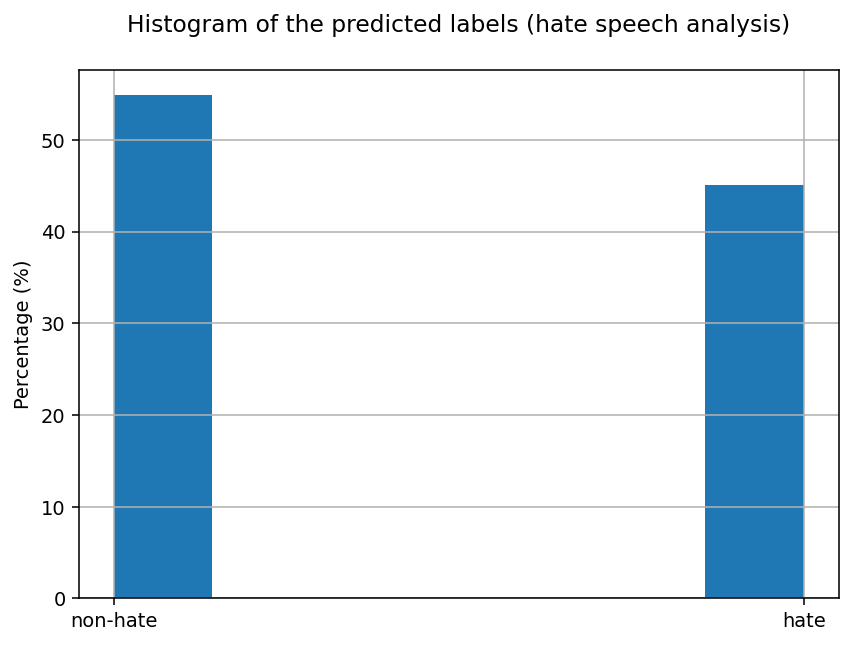

In [20]:
x = np.arange(n_labels)
bins = np.linspace(0, 1, 8)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of the predicted labels (hate speech analysis)\n')
df['messageHate.score'].hist(bins=bins, weights=np.ones_like(df[df.columns[0]]) * 100. / len(df))
plt.ylabel('Percentage (%)')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.grid(True)
plt.show ()

Bar plot of top actors

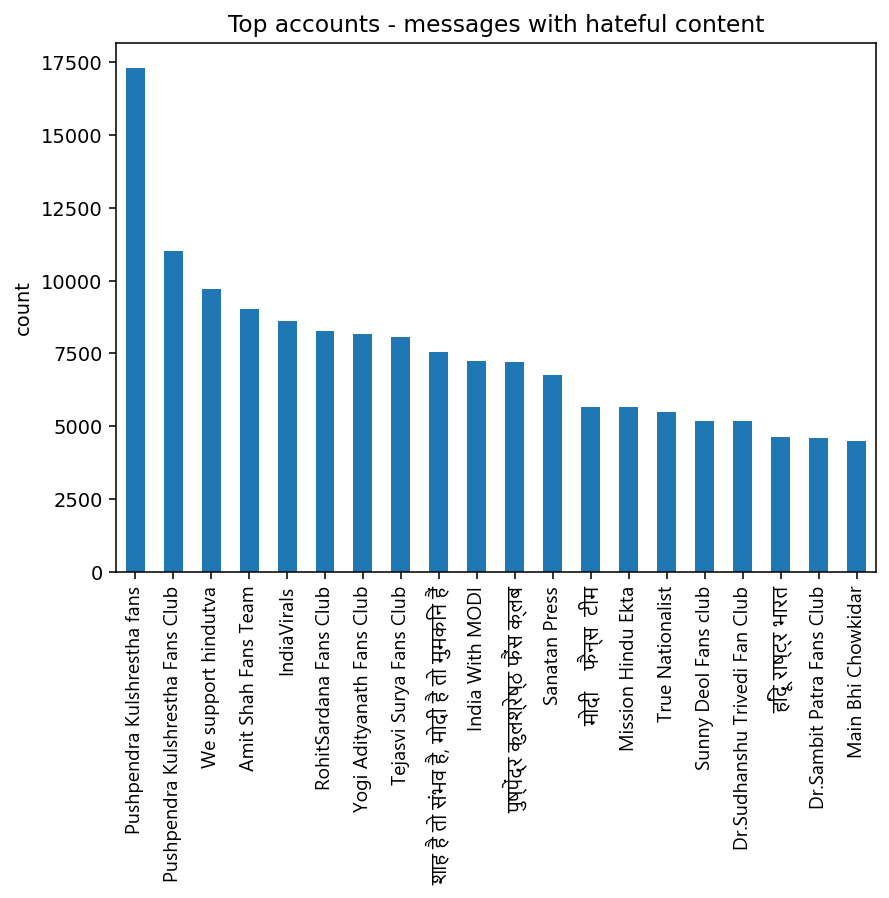

In [21]:
plt.figure(figsize=(7,5),dpi=140)

hate = df [df['messageHate.score'] == 1]
hate ['account.name'].value_counts()[:20].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/CrowdTangle-NLP/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)
#plt.xticks(rotation = 60)

plt.title('Top accounts - messages with hateful content')
plt.ylabel('count')

plt.show()